In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit
from scipy.signal import bessel, sosfiltfilt

import transport_signal_processing as tsp
from data_manager import DataManager

## Select and load events

In [2]:
# parameters
path = "K238A_25_1MKCl10mMHEPESpH7p8/MP446_P3_2/51p28uM/*"
level = 1
selected_only = True

# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)

# add full condition key
#df['condition'] = df.apply(lambda x: "{}-{}-{}".format(x['pore'], x['analyte'], x['voltage']), axis=1)
df['condition'] = df.apply(lambda x: "{}-{}-{}".format(x['pore'], x['voltage'], x['analyte']), axis=1)
#df['condition'] = df.apply(lambda x: "{}-{}-{}-{}-{}-{}".format(x['pore'], x['analyte'], x['voltage'], x['timestamp'], x['replica'], x['channel']), axis=1)

# keep only selected segments
df = df[(df['selected'] > (level-1))]
df

,pore,temperature,buffer,analyte,analyte_quantity,voltage,date,recording,channel,count,...,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel,condition
1,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221110,21,002,001,...,300.999995,2022-11-24_15:29:18,74.819853,10.907497,129,84.0,84.0,1.0,0.928571,K238A-100-MP446_P2_Cy5
2,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221110,21,002,003,...,299.999995,2022-11-24_15:29:18,56.413299,9.965107,89,58.0,58.0,1.0,0.965517,K238A-100-MP446_P2_Cy5
3,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221110,21,002,004,...,300.999995,2022-11-24_15:29:18,75.430279,10.720483,193,142.0,142.0,1.0,0.943662,K238A-100-MP446_P2_Cy5
4,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221110,21,002,007,...,300.999995,2022-11-24_15:29:18,75.790212,10.364539,224,146.0,146.0,1.0,0.958904,K238A-100-MP446_P2_Cy5
5,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221114,05,004,001,...,299.999995,2022-11-24_15:29:18,69.345535,10.773509,133,71.0,71.0,1.0,0.859155,K238A-100-MP446_P2_Cy5
6,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221117,10,003,001,...,300.999995,2022-11-24_15:29:18,70.965044,10.496870,257,151.0,151.0,1.0,0.847682,K238A-100-MP446_P2_Cy5
8,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221116,14,002,000,...,299.999995,2022-11-24_15:29:18,64.151582,10.098521,174,95.0,95.0,1.0,0.926316,K238A-100-MP446_P2_Cy5
9,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221116,15,002,000,...,299.999995,2022-11-24_15:29:18,68.985039,9.137811,272,141.0,141.0,1.0,0.815603,K238A-100-MP446_P2_Cy5
10,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221116,15,002,001,...,222.442875,2022-11-24_15:29:18,77.509943,10.229384,244,153.0,153.0,1.0,0.836601,K238A-100-MP446_P2_Cy5
11,K238A,25,1MKCl10mMHEPESpH7p8,MP446_P2_Cy5,25p64uM,100,221116,23,002,001,...,299.999995,2022-11-24_15:29:18,75.114448,12.863142,358,258.0,258.0,1.0,0.918605,K238A-100-MP446_P2_Cy5


In [3]:
df['condition'].unique()

array(['K238A-100-MP446_P2_Cy5', 'K238A-130-MP446_P2_Cy5'], dtype=object)

In [4]:
# parameters
key_sel = 'condition'

# load stats grouped by selected key
stats_dict = tsp.utils.load_stats_for_key(sigman, df.to_dict('records'), key_sel, selected_only=selected_only)

# find keys
key_sels = np.unique(df[key_sel].values)

events_dict = {}
for key in tqdm(key_sels):
    # subset
    dfs = df[df[key_sel] == key].copy()

    # load core events
    events_dict[key] = tsp.utils.load_core_events(sigman, dfs.to_dict('record'), selected_only=selected_only)

  0%|          | 0/2 [00:00<?, ?it/s]/home/lfkrapp/anaconda3/envs/tsp/lib/python3.9/site-packages/pandas/core/frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


### Average relative current distribution

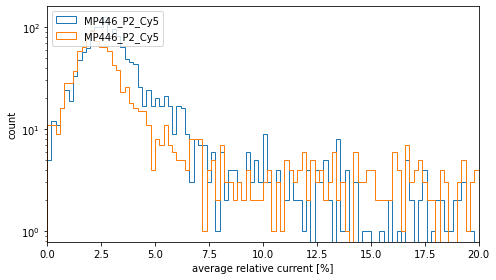

In [5]:
# parameters
I_min = 0.0
I_max = 20.0
res = 0.2

plt.figure(figsize=(7,4))
for key in key_sels:
    stats = stats_dict[key]
    
    mI = stats[:,1]    
    plt.hist(mI, range=(I_min, I_max), bins=int((I_max-I_min)/res), log=True, histtype='step', label=key.split('-')[-1])

plt.legend(loc='upper left')
plt.xlabel("average relative current [%]")
plt.ylabel("count")
plt.xlim(I_min, I_max)
plt.tight_layout()
plt.savefig("graphs/avg_rel_current_dist_{}.png".format(key), dpi=200)
plt.show()

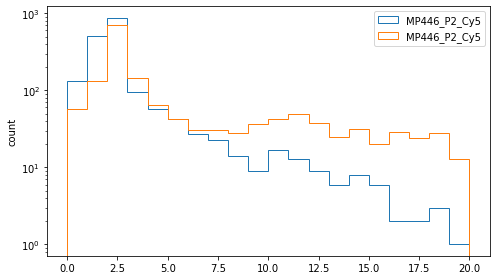

In [6]:
# parameters
I_min = 0.0
I_max = 20.0
res = 1.0

plt.figure(figsize=(7,4))
for key in key_sels:
    stats = stats_dict[key]
    
    mI = stats[:,2]
    plt.hist(mI, range=(I_min, I_max), bins=int((I_max-I_min)/res), log=True, histtype='step', label=key.split('-')[-1])
plt.legend(loc='best')
#plt.xlabel("average relative current [%]")
plt.ylabel("count")
plt.tight_layout()
plt.show()

### Relative current distribution

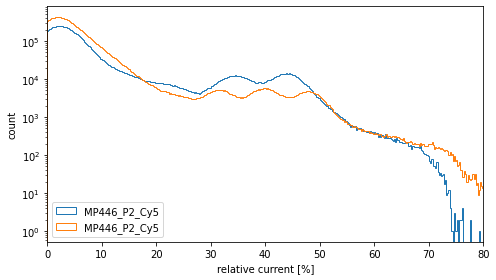

In [7]:
# parameters
I_min = 0.0
I_max = 80.0
res = 0.2

plt.figure(figsize=(7,4))
for key in key_sels:
    events = events_dict[key]

    I_all = np.concatenate(events)[:,1]    
    plt.hist(I_all, range=(I_min, I_max), bins=int((I_max-I_min)/res), log=True, histtype='step', label=key.split('-')[-1])
    
plt.legend(loc='lower left')
plt.xlabel("relative current [%]")
plt.ylabel("count")
plt.xlim(I_min, I_max)
plt.tight_layout()
plt.savefig("graphs/rel_current_dist_{}.png".format(key), dpi=200)
plt.show()

K238A-100-MP446_P2_Cy5: mean=31.277ms, median=4.828ms
K238A-130-MP446_P2_Cy5: mean=56.722ms, median=5.312ms


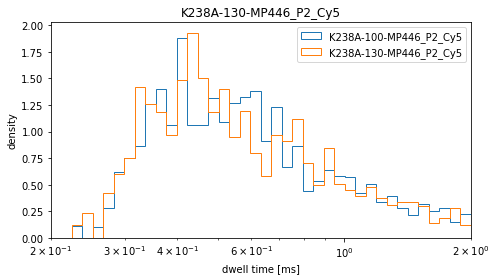

In [8]:
dwt_min = 2e-1
dwt_max = 2e0

plt.figure(figsize=(7,4))
for key in key_sels:
    stats = stats_dict[key]
    
    hist, bins = np.histogram(stats[:,0], bins=40, range=(dwt_min, dwt_max))
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(stats[:,0], bins=logbins, histtype='step', density=True, label=key)
    plt.xscale('log')
    
    print("{}: mean={:.3f}ms, median={:.3f}ms".format(key, np.mean(stats[:,0]), np.median(stats[:,0])))

plt.title(key)
plt.ylabel("density")
plt.xlabel("dwell time [ms]")
plt.xlim(1e-1, 1e1)
plt.legend(loc='best')
plt.xlim(dwt_min, dwt_max)
plt.tight_layout()
plt.savefig("graphs/dwell_time_dist_{}.png".format(key), dpi=200)
plt.show()

In [9]:
key_sels_dict = {}
for key in key_sels:
    key0 = '-'.join(key.split('-')[:2])
    key1 = '-'.join(key.split('-')[2:])
    if key0 in key_sels_dict:
        key_sels_dict[key0].append(key1)
    else:
        key_sels_dict[key0] = [key1]

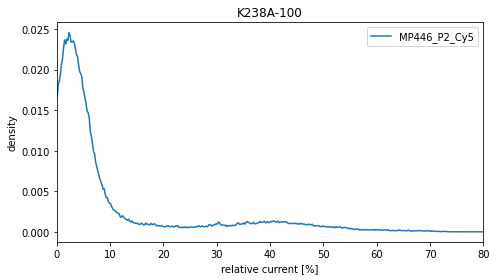

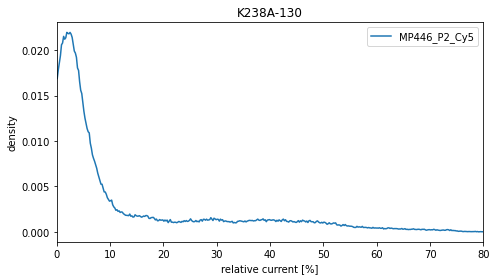

In [10]:
# parameters
I_min = 0.0  #-5.0
I_max = 80.0  #100.0
res = 0.2

for key0 in key_sels_dict:
    plt.figure(figsize=(7,4))
    
    for key1 in key_sels_dict[key0]:
        key = key0+'-'+key1
        events = events_dict[key]

        h = np.zeros(int((I_max-I_min)/res))
        for evt in events:
            c, x = np.histogram(evt[:,1], range=(I_min, I_max), bins=int((I_max-I_min)/res))
            h += c / (np.sum(c)+1e-6)
            x = 0.5*(x[:-1]+x[1:])
        h = h / len(events)

        plt.plot(x,h,label=key1)

    plt.legend(loc='best')
    plt.title(key0)
    plt.xlabel("relative current [%]")
    plt.ylabel("density")
    plt.xlim(I_min, I_max)
    plt.tight_layout()
    plt.savefig("graphs/rel_current_dist_{}.png".format(key), dpi=200)
    plt.show()

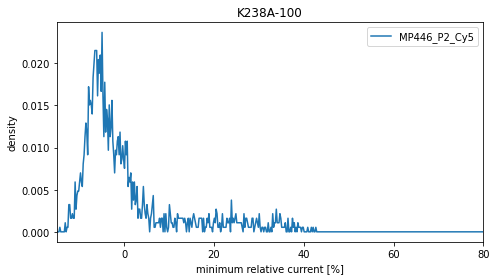

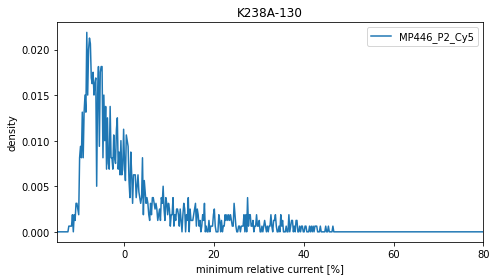

In [11]:
# parameters
I_min = -15.0  #-5.0
I_max = 80.0  #100.0
res = 0.2

for key0 in key_sels_dict:
    plt.figure(figsize=(7,4))
    
    for key1 in key_sels_dict[key0]:
        key = key0+'-'+key1
        events = events_dict[key]
        
        Imins = np.array([np.min(evt[:,1]) for evt in events])
        
        #plt.hist(Imins, bins=100, density=True, histtype='step', label=key1)
        
        c, x = np.histogram(Imins, range=(I_min, I_max), bins=int((I_max-I_min)/res))
        h = c / (np.sum(c)+1e-6)
        x = 0.5*(x[:-1]+x[1:])

        #h = np.zeros(int((I_max-I_min)/res))
        #for evt in events:
            #c, x = np.histogram(evt[:,1], range=(I_min, I_max), bins=int((I_max-I_min)/res))
            #h += c / (np.sum(c)+1e-6)
            #x = 0.5*(x[:-1]+x[1:])
        #h = h / len(events)

        plt.plot(x,h,label=key1)

    plt.xlim(I_min, I_max)
    plt.title(key0)
    plt.xlabel("minimum relative current [%]")
    plt.ylabel("density")
    plt.legend(loc='best')
    plt.tight_layout()
    #plt.savefig("graphs/rel_current_dist_{}.png".format(key), dpi=200)
    plt.show()

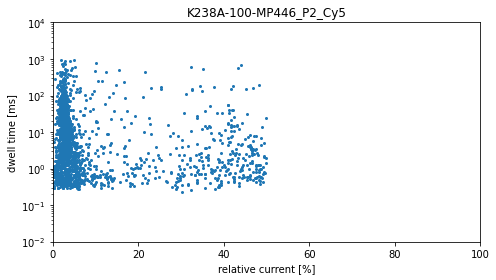

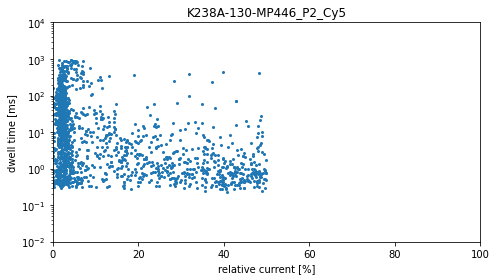

In [12]:
# parameters
ldwt_min = -1.0
ldwt_max = 3.5
res = 0.2

for key in key_sels:
    stats = stats_dict[key]
    
    plt.figure(figsize=(7,4))
    plt.semilogy(stats[:,1],stats[:,0],'.',ms=4.0)
    plt.title(key)
    plt.xlabel("relative current [%]")
    plt.ylabel("dwell time [ms]")
    plt.xlim(0.0, 100.0)
    plt.ylim(1e-2, 1e4)
    plt.tight_layout()
    #plt.savefig("graphs/rel_current_dist_{}.png".format(key), dpi=200)
    plt.show()

In [13]:
def gauss(x, A, mu, sigma):
    return np.abs(A) * np.exp(-0.5*np.square((x - mu))/np.square(sigma))

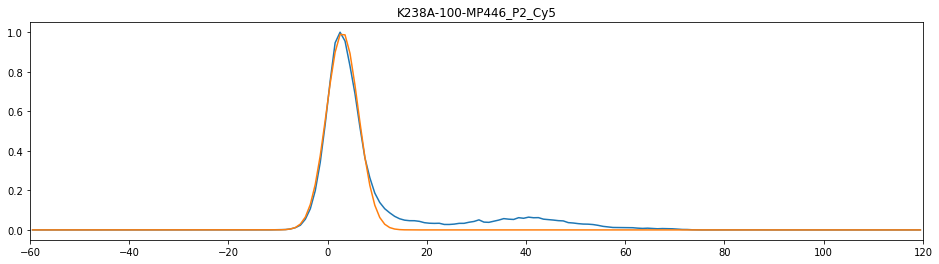

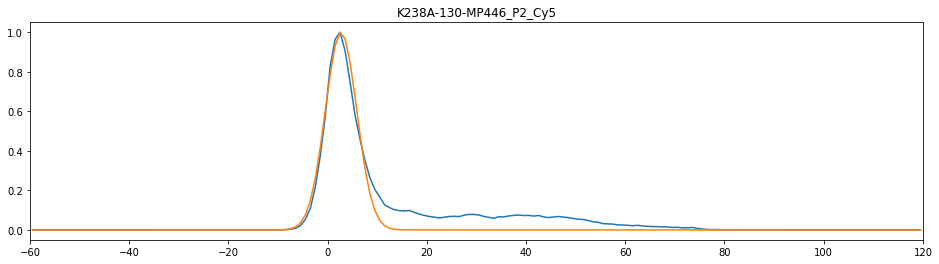

In [14]:
I_min = -60.0
I_max = 120.0
res = 1.0

for key0 in key_sels_dict:    
    for key1 in key_sels_dict[key0]:
        key = key0+'-'+key1
        events = events_dict[key]
        
        h = np.zeros(int((I_max-I_min)/res))
        for evt in events:
            c, x = np.histogram(evt[:,1], range=(I_min, I_max), bins=int((I_max-I_min)/res))
            h += c / (np.sum(c)+1e-6)
            x = 0.5*(x[:-1]+x[1:])
        h = h / np.max(h)

        def cstr_gauss(x, mu, sigma):
            return np.exp(-0.5*np.square((x - mu))/np.square(sigma))

        popt, pcov = curve_fit(cstr_gauss, x, h, p0=[10.0, 20.0])
        p = gauss(x, 1.0, popt[0], popt[1])

        plt.figure(figsize=(16,4))
        plt.plot(x,h)
        plt.plot(x,p)
        plt.xlim(I_min, I_max)
        plt.title(key)
        plt.show()

In [15]:
mu, sigma = popt

In [16]:
mu, sigma

(2.6957520911027424, 3.1639454562796305)

In [17]:
def envelope(x, r):
    X = np.stack([np.pad(x, (i,2*r-i), 'constant', constant_values=(np.nan,np.nan)) for i in range(2*r+1)])[:,r:-r]

    return np.nanmax(X,0), np.nanmin(X,0)

In [18]:
# define smoothing function
def smooth(x, dt):
    #bessel filter
    cutoff = 5000  # cutoff frequency in Hz
    order = 8  # order of the filter, for most general-purpose high- or low-pass filters, the terms pole and order may be used interchangeably and completely describe the rolloff rate
    # get the filter coefficients
    sos = bessel(order, cutoff, btype='lowpass', output='sos', fs=1.0/dt, norm='mag')  # mag: the filter is normalized such that the gain magnitude is -3dB at angular cutoff frequency
    # apply the filter with the filter coefficients
    return sosfiltfilt(sos, x)

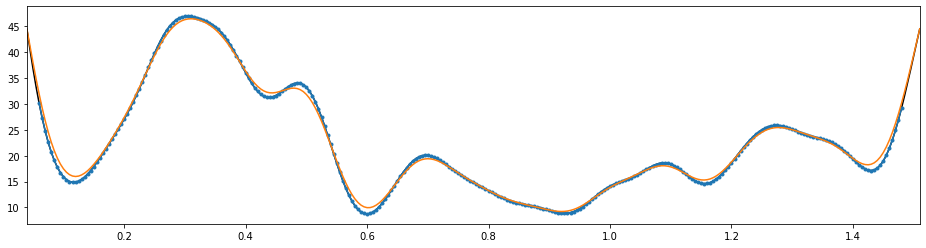

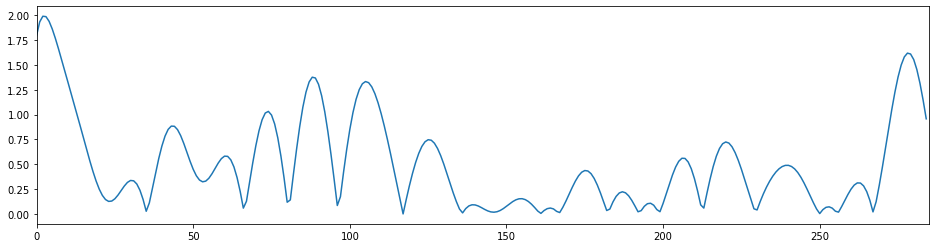

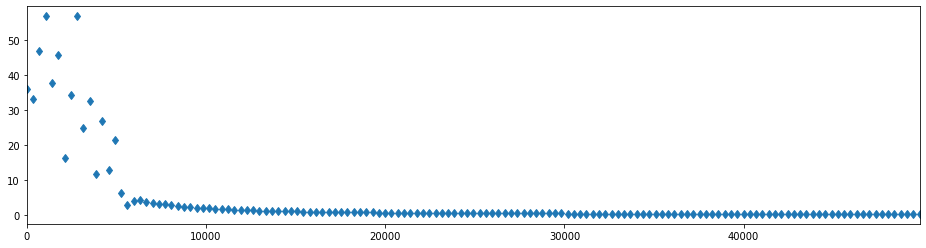

In [19]:
dt = 1e-5
d_thr = 20.0

i = np.random.choice(len(events))
#i = 3181
#i = 10219
#i = 6679
evt = events[i]
y = evt[:,1].copy()
t = evt[:,0].copy()

ys = smooth(y, dt)

y_thr = np.mean(y) + np.std(y)
i0, i1 = np.where(y < y_thr)[0][[0,-1]]
y_raw = y.copy()
t_raw = t.copy()
ys_raw = ys.copy()
y = y[i0:i1]
t = t[i0:i1]
ys = ys[i0:i1]

y_sup, y_inf = envelope(y, 1)

plt.figure(figsize=(16,4))
plt.plot(t_raw,y_raw,'k-')
plt.plot(t,y,'.-')
plt.plot(t_raw,ys_raw)
#plt.plot([t[0], t[-1]], [mu+sigma*3]*2, 'k--')
#plt.plot([t[0], t[-1]], [mu-sigma*3]*2, 'k--')
#plt.plot(t, y_sup)
#plt.plot(t, y_inf)
plt.xlim(t_raw[0], t_raw[-1])
plt.show()

plt.figure(figsize=(16,4))
plt.plot(np.abs(y - ys))
plt.xlim(0, len(y))
plt.show()

sp = np.fft.fft(y - ys)
freq = np.fft.fftfreq(y.shape[0], d=dt)

plt.figure(figsize=(16,4))
plt.plot(freq, np.abs(sp), 'd')
plt.xlim(0.0, np.max(freq))
plt.show()

K238A-100-MP446_P2_Cy5 1860


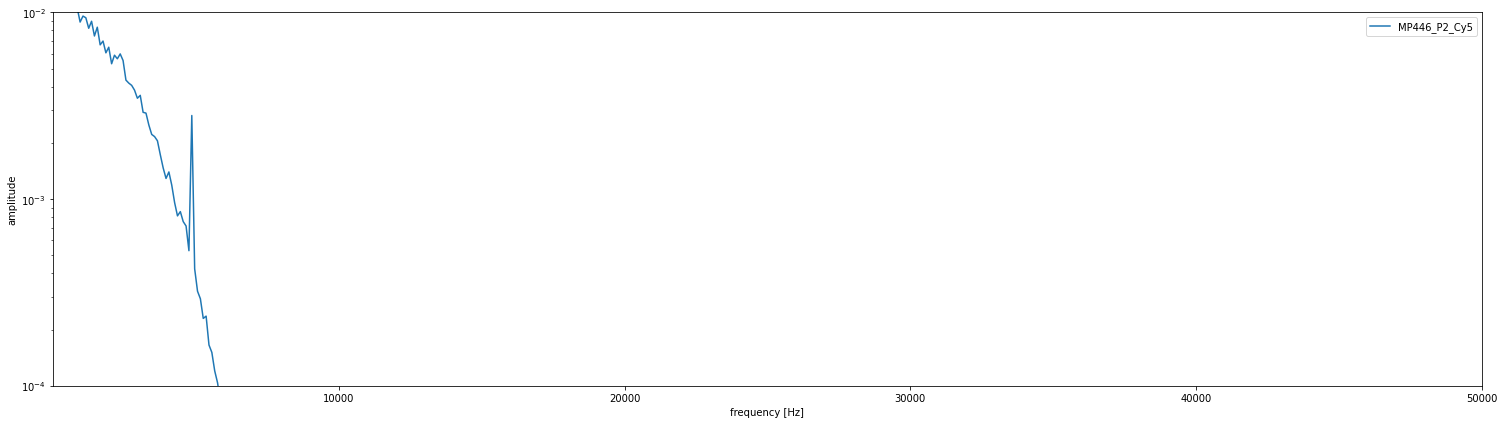

K238A-130-MP446_P2_Cy5 1600


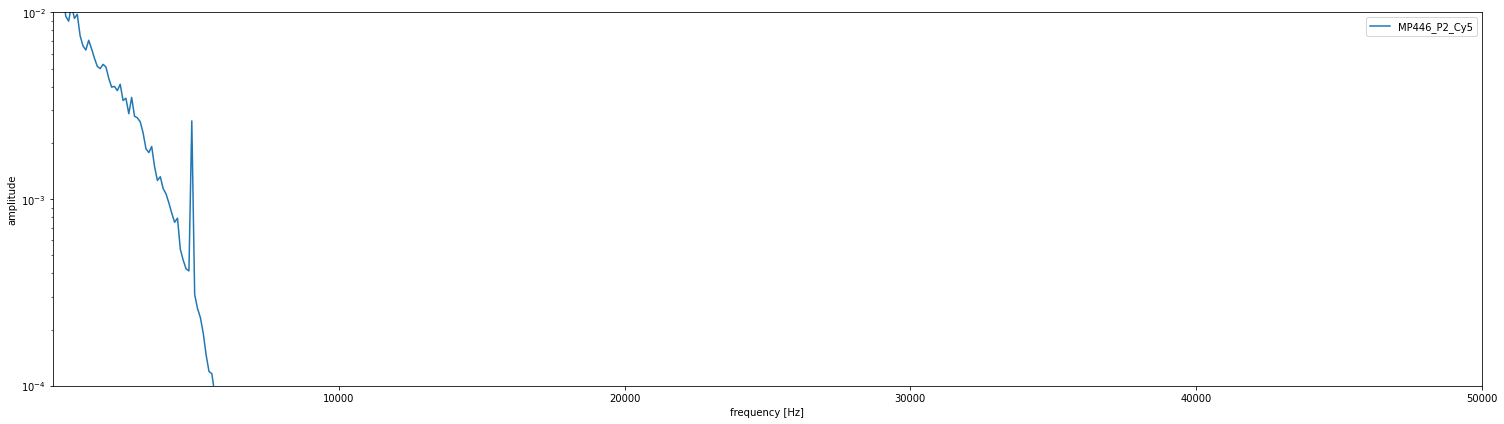

In [20]:
fres = 100.0
dt = 1e-5  # s

for key0 in key_sels_dict:    
    plt.figure(figsize=(21,6))
    for key1 in key_sels_dict[key0]:
        key = key0+'-'+key1
        events = events_dict[key]
        print(key, len(events))

        sp_l, freq_l = [], []
        for evt in events:
            if len(evt) > 1:
                y = evt[:,1].copy()
                y_thr = np.mean(y) + np.std(y)
                i0, i1 = np.where(y < y_thr)[0][[0,-1]]
                y = y[i0:i1]
                if len(y) > 0:
                    y = y - np.mean(y)
                    sp_l.append(np.fft.fft(y))
                    freq_l.append(np.fft.fftfreq(y.shape[0], d=dt))

        sp = np.abs(np.concatenate(sp_l))
        freq = np.concatenate(freq_l)

        x = np.linspace(np.min(freq), np.max(freq), int((np.max(freq)-np.min(freq))/fres))
        c = np.zeros(len(x)-1)
        for i in range(len(x)-1):
            m = ((x[i] < freq) & (freq < x[i+1]))
            c[i] = np.max(sp[m])

        h = c / np.sum(c)

        x = 0.5*(x[1:]+x[:-1])
        
        plt.semilogy(x,h, label=key1)
        
    plt.xlim(dt, 0.5 / dt)
    plt.ylim(1e-4, 1e-2)
    plt.legend(loc='best')
    plt.ylabel("amplitude")
    plt.xlabel("frequency [Hz]")
    plt.tight_layout()
    plt.savefig("graphs/fft_asyn-ptms.png", dpi=200)
    plt.show()

In [ ]:
fres = 10.0
dt = 1e-5  # s

t = np.arange(200)*dt*1e3

for key0 in key_sels_dict:    
    for key1 in key_sels_dict[key0]:
        key = key0+'-'+key1
        events = events_dict[key]
        print(key, len(events))

        sp_l, freq_l = [], []
        for evt in events:
            if len(evt) > 1:
                y = evt[:,1].copy()
                y_thr = np.mean(y) + 0.1*np.std(y)
                i0, i1 = np.where(y < y_thr)[0][[0,-1]]
                y = y[i0:i1]
                if len(y) > 0:
                    y = y - np.mean(y)
                    sp_l.append(np.fft.fft(y))
                    freq_l.append(np.fft.fftfreq(y.shape[0], d=dt))

        sp = np.concatenate(sp_l)
        freq = np.concatenate(freq_l)

        x = np.fft.fftfreq(t.shape[0], d=dt)
        c = np.zeros(len(x), dtype=np.dtype('complex128'))
        ids_loc = np.argmin(np.abs(x.reshape(-1,1) - freq.reshape(1,-1)), axis=0)
        for i in np.unique(ids_loc):
            m = (ids_loc == i)
            #spi = sp[m]
            #z = np.abs(spi)
            #c[i] = np.sum(spi * (z / np.sum(z)))
            #c[i] = spi[np.argmax(np.abs(spi))]
            #c[i] = np.mean(sp[m])
            c[i] = np.max(sp[m])

        x = 0.5*(x[1:]+x[:-1])
        
        r = np.fft.ifft(c)

        plt.figure()
        plt.plot(t, np.abs(r))
        plt.plot(t, r.real)
        #plt.plot(t, r.imag)
        #plt.ylim(4,10)
        plt.show()

K238A-100-MP446_P2_Cy5 1860
